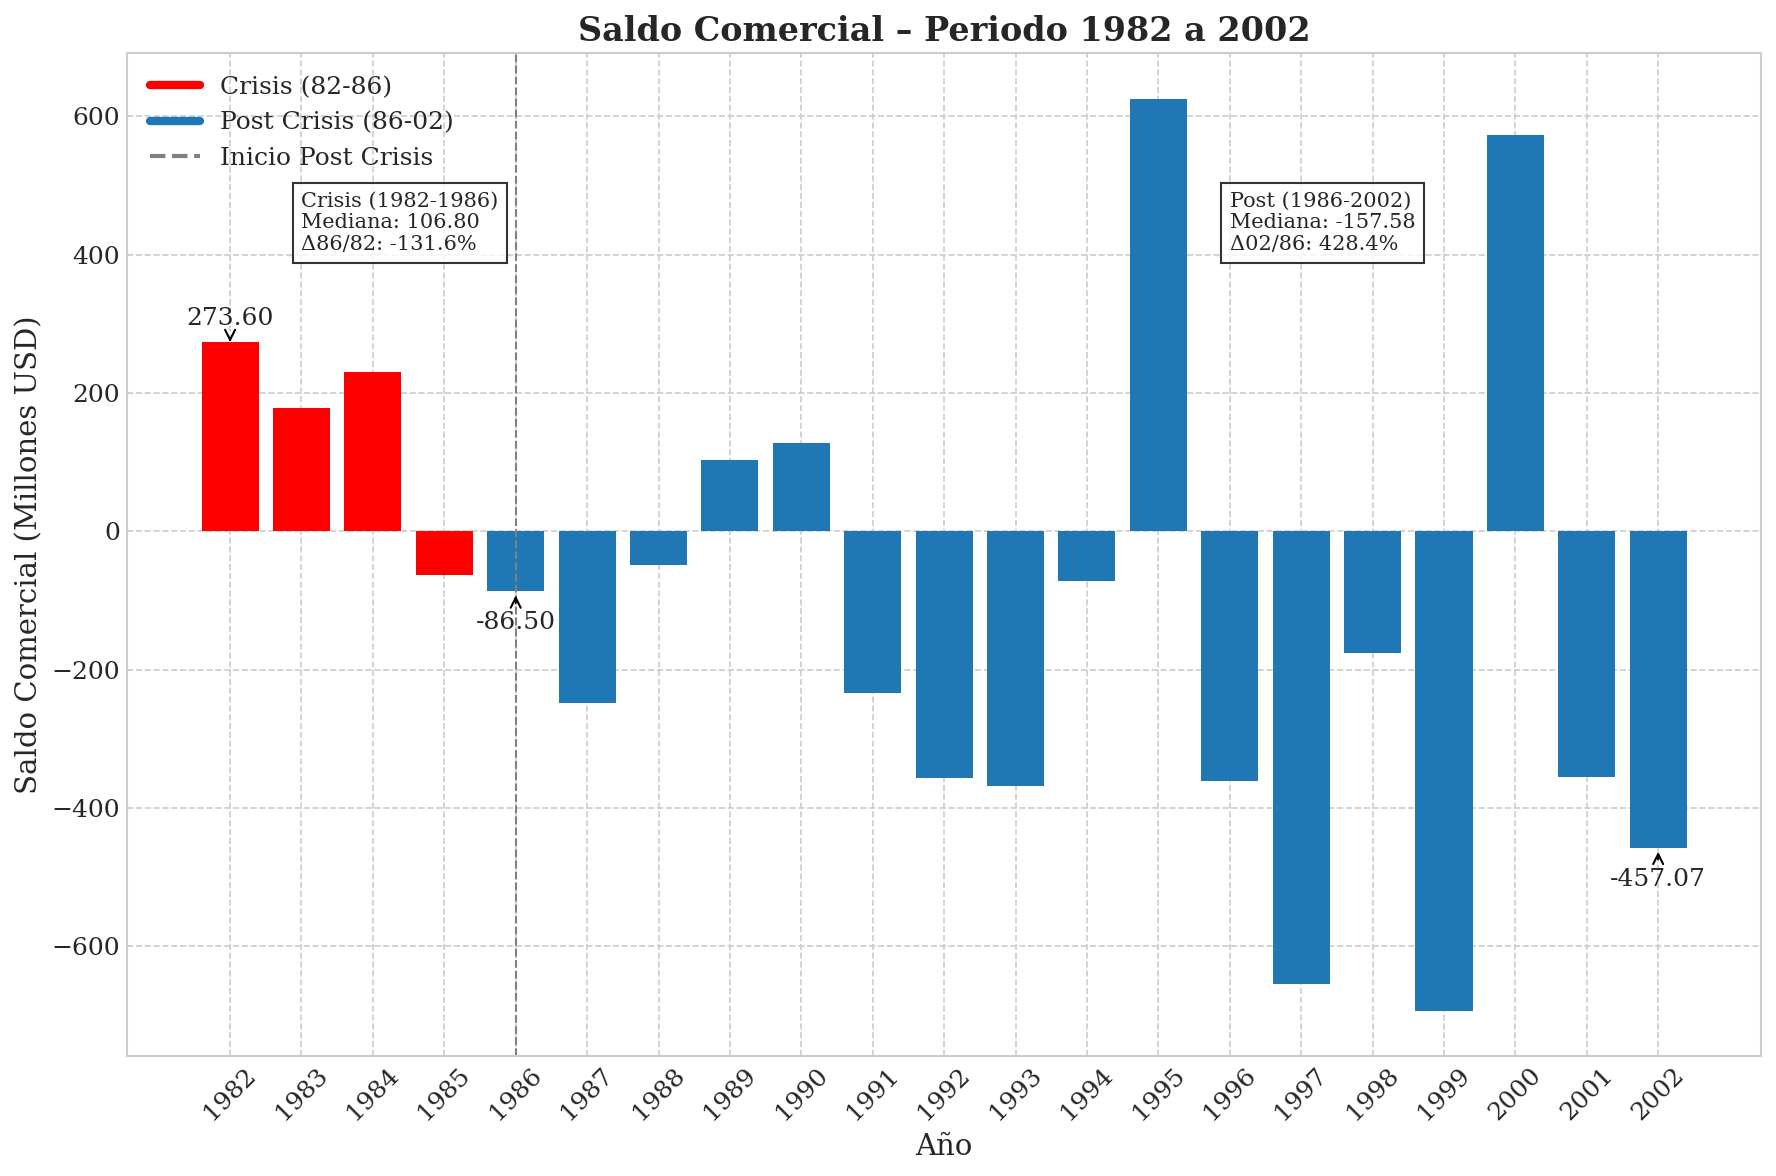

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
import seaborn as sns

# --- Configuración del estilo profesional ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':    'serif',
    'font.size':      12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'grid.linestyle': '--',
    'lines.linewidth':2,
    'figure.dpi':     150,
    'savefig.bbox':   'tight'
})

def cuadro_estadisticas(serie):
    mean = serie.loc[1982:1986].mean()
    g86  = (serie.loc[1986] - serie.loc[1982]) / serie.loc[1982] * 100
    return (f"Crisis (1982‑1986)\nMediana: {mean:.2f}\n"
            f"Δ86/82: {g86:.1f}%")

def cuadro_estadisticas_post(serie):
    mean = serie.loc[1986:2002].mean()
    g02  = (serie.loc[2002] - serie.loc[1986]) / serie.loc[1986] * 100
    return (f"Post (1986‑2002)\nMediana: {mean:.2f}\n"
            f"Δ02/86: {g02:.1f}%")

# --- Conexión y carga de datos ---
conn = sqlite3.connect('../../../db/proyectomacro.db')
df_balanza = pd.read_sql_query("SELECT * FROM balanza_comercial", conn)
conn.close()

# --- Preprocesamiento: índice y periodo 1982‑2002 ---
df_balanza.set_index('año', inplace=True)
df_balanza = df_balanza.loc[1982:2002]
df_full = df_balanza

# --- Segmentar en crisis (82‑86) y post (86‑02) ---
df_pre  = df_full.loc[1982:1986]
df_post = df_full.loc[1986:2002]

# --- Directorio de salida ---
output_dir = "../../../assets/tesis/neoliberalismo/serie_completa"
os.makedirs(output_dir, exist_ok=True)

# --- Crear gráfico de barras ---
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['red' if año < 1986 else '#1f77b4' for año in df_full.index]
bars = ax.bar(df_full.index, df_full['saldo_comercial'], color=colors)

# Línea vertical separadora en 1986
ax.axvline(x=1986, color='gray', linestyle='--', linewidth=1, label='Inicio Post Crisis')

# Diccionario con offset vertical para cada año
offsets_anotacion = {
    1982: 25,
    1986: -55,
    2002: -55,  # puedes ajustar este valor si el texto se superpone con el eje o barra
}
# Anotaciones en años clave: 1982, 1986, 2002
for year in [1982, 1986, 2002]:
    if year in df_full.index:
        value = df_full.loc[year, 'saldo_comercial']
        offset = offsets_anotacion.get(year, 13)  # valor por defecto: 13
        ax.annotate(f"{value:.2f}",
                    xy=(year, value),
                    xytext=(year, value + offset),
                    ha='center',
                    fontsize=12,
                    arrowprops=dict(facecolor='black', arrowstyle='->'))
# Cuadros de estadísticas descriptivas
ax.text(1983, df_full['saldo_comercial'].max() * 0.65,
        cuadro_estadisticas(df_pre['saldo_comercial']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

ax.text(1996, df_full['saldo_comercial'].max() * 0.65,
        cuadro_estadisticas_post(df_post['saldo_comercial']),
        fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# Etiquetas, título y leyenda
ax.set_title('Saldo Comercial – Periodo 1982 a 2002', fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Saldo Comercial (Millones USD)')
ax.set_xticks(df_full.index[::])
ax.set_xticklabels(df_full.index[::], rotation=45)

ax.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=4, label='Crisis (82‑86)'),
    plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Post Crisis (86‑02)'),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Inicio Post Crisis')
])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "saldo_comercial.png"))
plt.show()
plt.close()
